# Orthogonal Range Search

This notebook shows the process of **orthogonal range search** in computational geometry using a **KD-Tree**.

1. **KD-Tree Construction**: Recursively partition 2D points by alternating x/y median splits  
2. **Visualization**: Show the recursive splitting regions  
3. **Range Search**: Query an axis-aligned rectangle and visualize which subtrees are visited, reported, or pruned

## Part 1 — KD-Tree Construction

Recursively split points by the **median** along alternating axes (x at even depth, y at odd depth). Each internal node stores a splitting value; leaves store individual points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

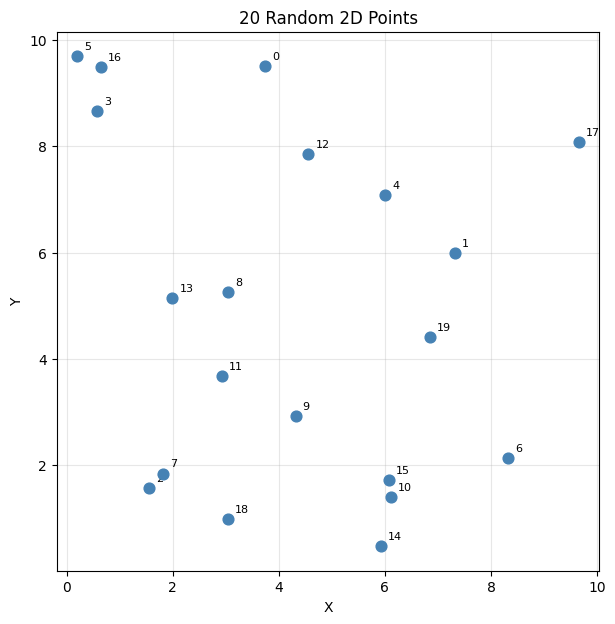

In [ ]:
# Generate random 2D points
np.random.seed(27)
n_points = 20
points = np.random.rand(n_points, 2) * 10

plt.figure(figsize=(7, 7))
plt.scatter(points[:, 0], points[:, 1], s=60, c='steelblue', zorder=5)
for i, p in enumerate(points):
    plt.annotate(str(i), p, textcoords='offset points', xytext=(5, 5), fontsize=8)
plt.title(f'{n_points} Random 2D Points')
plt.xlabel('X'); plt.ylabel('Y')
plt.axis('equal'); plt.grid(True, alpha=0.3)
plt.show()

In [3]:
# ============================================
# KD-Tree Node & Construction
# ============================================

class KDNode:
    """A node in the KD-Tree."""
    def __init__(self, point=None, axis=None, split_val=None,
                 left=None, right=None, region=None, depth=0):
        self.point = point          # (x, y) — stored at every node
        self.axis = axis            # 0 = x-split, 1 = y-split
        self.split_val = split_val  # the coordinate value of the split
        self.left = left            # left / bottom child
        self.right = right          # right / top child
        self.region = region        # bounding box [x_lo, x_hi, y_lo, y_hi]
        self.depth = depth
        self.idx = None             # original index in points array

    @property
    def is_leaf(self):
        return self.left is None and self.right is None


def build_kdtree(points, indices=None, depth=0,
                 region=None, build_log=None):
    """
    Recursively build a 2D KD-Tree.
    
    Parameters
    ----------
    points   : (N, 2) array
    indices  : original indices into the global points array
    depth    : current depth (axis = depth % 2)
    region   : [x_lo, x_hi, y_lo, y_hi] bounding box
    build_log: list to record construction steps for animation
    
    Returns
    -------
    KDNode  (root of the subtree)
    """
    if indices is None:
        indices = np.arange(len(points))
    if region is None:
        pad = 0.5
        region = [points[:, 0].min() - pad, points[:, 0].max() + pad,
                  points[:, 1].min() - pad, points[:, 1].max() + pad]
    if build_log is None:
        build_log = []

    n = len(indices)
    if n == 0:
        return None

    axis = depth % 2  # 0 → split on x, 1 → split on y

    # Sort by current axis and pick median
    sorted_idx = indices[np.argsort(points[indices, axis])]
    median_pos = n // 2
    median_idx = sorted_idx[median_pos]
    split_val = points[median_idx, axis]

    node = KDNode(
        point=points[median_idx],
        axis=axis,
        split_val=split_val,
        region=list(region),
        depth=depth
    )
    node.idx = int(median_idx)

    # Record this split step
    build_log.append({
        'depth': depth,
        'axis': axis,
        'split_val': split_val,
        'point': points[median_idx].copy(),
        'point_idx': int(median_idx),
        'region': list(region),
        'n_points': n
    })

    left_indices = sorted_idx[:median_pos]
    right_indices = sorted_idx[median_pos + 1:]

    # Child regions
    left_region = list(region)
    right_region = list(region)
    if axis == 0:  # x-split
        left_region[1] = split_val    # x_hi shrinks
        right_region[0] = split_val   # x_lo grows
    else:          # y-split
        left_region[3] = split_val    # y_hi shrinks
        right_region[2] = split_val   # y_lo grows

    node.left = build_kdtree(points, left_indices, depth + 1,
                              left_region, build_log)
    node.right = build_kdtree(points, right_indices, depth + 1,
                               right_region, build_log)
    return node


# Build the tree
build_log = []
root = build_kdtree(points, build_log=build_log)
print(f"KD-Tree built: {len(build_log)} splits recorded")

KD-Tree built: 20 splits recorded


### KD-Tree Construction Animation

Watch the tree being built step by step:
- **Red dashed line**: the current split (vertical for x-axis, horizontal for y-axis)
- **Red diamond**: the median point chosen at this step
- **Coloured rectangles**: the resulting sub-regions
- **Grey points**: points not yet processed in the current branch

In [ ]:
# ============================================
# Animation: KD-Tree Construction
# ============================================

def create_kdtree_build_animation(points, build_log):
    """Animate the KD-Tree construction step by step."""
    pad = 0.5
    x_lo, x_hi = points[:, 0].min() - pad, points[:, 0].max() + pad
    y_lo, y_hi = points[:, 1].min() - pad, points[:, 1].max() + pad

    total_frames = len(build_log) + 1  # +1 for initial frame
    # Depth-based colours for split lines
    depth_colors_x = ['#e74c3c', '#e67e22', '#f39c12', '#d35400', '#c0392b']
    depth_colors_y = ['#2980b9', '#27ae60', '#8e44ad', '#16a085', '#2c3e50']

    fig, ax = plt.subplots(figsize=(9, 9))

    def update(frame):
        ax.clear()
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.15)

        # Draw all points dimmed
        ax.scatter(points[:, 0], points[:, 1], c='lightgrey', s=40, zorder=2)

        steps_to_show = frame  # 0 = only points, 1..N = splits

        # Draw accumulated splits
        for i in range(min(steps_to_show, len(build_log))):
            step = build_log[i]
            axis = step['axis']
            sv = step['split_val']
            region = step['region']
            depth = step['depth']
            is_current = (i == steps_to_show - 1)

            # Split line
            if axis == 0:  # vertical line (x-split)
                c = depth_colors_x[depth % len(depth_colors_x)]
                lw = 3 if is_current else 1.5
                ls = '--' if is_current else '-'
                ax.plot([sv, sv], [region[2], region[3]], color=c,
                        linewidth=lw, linestyle=ls, alpha=0.9 if is_current else 0.6, zorder=4)
            else:  # horizontal line (y-split)
                c = depth_colors_y[depth % len(depth_colors_y)]
                lw = 3 if is_current else 1.5
                ls = '--' if is_current else '-'
                ax.plot([region[0], region[1]], [sv, sv], color=c,
                        linewidth=lw, linestyle=ls, alpha=0.9 if is_current else 0.6, zorder=4)

            # Region rectangle (faint)
            if is_current:
                r = region
                rect = patches.Rectangle((r[0], r[2]), r[1] - r[0], r[3] - r[2],
                                          linewidth=2, edgecolor=c,
                                          facecolor=c, alpha=0.07, zorder=1)
                ax.add_patch(rect)

            # Median point
            pt = step['point']
            if is_current:
                ax.scatter(*pt, c='red', s=200, marker='D', edgecolors='darkred',
                           linewidths=2, zorder=8)
                label = f"p{step['point_idx']}  ({'x' if axis == 0 else 'y'}={sv:.2f})"
                ax.annotate(label, pt, textcoords='offset points', xytext=(10, 10),
                            fontsize=10, fontweight='bold', color='red',
                            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.85))
            else:
                ax.scatter(*pt, c='black', s=50, marker='o', zorder=6)

        # Redraw all points on top (solid for already-split ones)
        placed = set()
        for i in range(min(steps_to_show, len(build_log))):
            placed.add(build_log[i]['point_idx'])
        placed_idx = list(placed)
        remain_idx = [j for j in range(len(points)) if j not in placed]
        if remain_idx:
            ax.scatter(points[remain_idx, 0], points[remain_idx, 1],
                       c='steelblue', s=45, zorder=5, alpha=0.5)
        if placed_idx:
            ax.scatter(points[placed_idx, 0], points[placed_idx, 1],
                       c='black', s=50, zorder=6)

        if steps_to_show == 0:
            ax.set_title('KD-Tree Construction — Initial Points', fontsize=13)
        elif steps_to_show <= len(build_log):
            step = build_log[steps_to_show - 1]
            axis_name = 'X' if step['axis'] == 0 else 'Y'
            ax.set_title(f"Step {steps_to_show}/{len(build_log)}:  "
                         f"Split on {axis_name} at {step['split_val']:.2f}  "
                         f"(depth {step['depth']})", fontsize=13)
        else:
            ax.set_title('KD-Tree Construction Complete', fontsize=13)

    anim = FuncAnimation(fig, update, frames=total_frames, interval=800, repeat=True)
    plt.close(fig)
    return anim

anim_build = create_kdtree_build_animation(points, build_log)
display(HTML(anim_build.to_jshtml()))
print(f"Construction animation: {len(build_log)} steps ✓")

Construction animation: 20 steps ✓


## Part 2 — Orthogonal Range Search

Given an axis-aligned query rectangle $[x_{lo}, x_{hi}] \times [y_{lo}, y_{hi}]$, traverse the KD-Tree:

| Case | Action |
|------|--------|
| Node region **fully inside** query | Report all points in subtree |
| Node region **fully outside** query | Prune (skip subtree) |
| **Partial overlap** | Check this node's point; recurse into children |

The animation colour-codes each visited node:
- 🟢 **Green** — reported (inside query)
- 🔴 **Red** — pruned (outside query)
- 🟡 **Yellow** — partially overlapping, needs recursion

In [5]:
# ============================================
# Range Search on the KD-Tree
# ============================================

def region_fully_inside(region, query):
    """Check if region is fully contained in query [qx_lo, qx_hi, qy_lo, qy_hi]."""
    return (region[0] >= query[0] and region[1] <= query[1] and
            region[2] >= query[2] and region[3] <= query[3])

def region_intersects(region, query):
    """Check if region overlaps the query rectangle."""
    return not (region[1] < query[0] or region[0] > query[1] or
                region[3] < query[2] or region[2] > query[3])

def point_in_query(pt, query):
    """Check if a point is inside the query rectangle."""
    return (query[0] <= pt[0] <= query[1] and query[2] <= pt[1] <= query[3])


def range_search(node, query, search_log=None):
    """
    Orthogonal range search on the KD-tree.
    
    Returns list of point indices inside the query rectangle.
    Logs every visited node for animation.
    """
    if node is None:
        return []
    if search_log is None:
        search_log = []

    region = node.region

    # Case 1: fully outside → prune
    if not region_intersects(region, query):
        search_log.append({
            'action': 'prune',
            'point': node.point.copy(),
            'point_idx': node.idx,
            'region': list(region),
            'depth': node.depth
        })
        return []

    # Case 2: fully inside → report entire subtree
    if region_fully_inside(region, query):
        reported = collect_subtree(node)
        search_log.append({
            'action': 'report_subtree',
            'point': node.point.copy(),
            'point_idx': node.idx,
            'region': list(region),
            'depth': node.depth,
            'reported': reported
        })
        return reported

    # Case 3: partial overlap → check point, recurse
    result = []
    inside = point_in_query(node.point, query)
    search_log.append({
        'action': 'visit',
        'point': node.point.copy(),
        'point_idx': node.idx,
        'region': list(region),
        'depth': node.depth,
        'point_inside': inside
    })
    if inside:
        result.append(node.idx)

    result += range_search(node.left, query, search_log)
    result += range_search(node.right, query, search_log)
    return result


def collect_subtree(node):
    """Collect all point indices in the subtree rooted at node."""
    if node is None:
        return []
    return [node.idx] + collect_subtree(node.left) + collect_subtree(node.right)


# Define a query rectangle
query = [2.0, 7.0, 3.0, 8.0]  # [x_lo, x_hi, y_lo, y_hi]

search_log = []
found = range_search(root, query, search_log)
print(f"Query: x∈[{query[0]}, {query[1]}], y∈[{query[2]}, {query[3]}]")
print(f"Found {len(found)} points: indices {found}")
print(f"Search visited {len(search_log)} nodes")

Query: x∈[2.0, 7.0], y∈[3.0, 8.0]
Found 5 points: indices [8, 11, 19, 12, 4]
Search visited 18 nodes


### Range Search Animation

Step through the search traversal and see each node being **visited** (yellow), **reported** (green), or **pruned** (red).

In [6]:
# ============================================
# Animation: Range Search Traversal
# ============================================

def draw_all_splits(ax, build_log, alpha=0.35):
    """Draw all KD-tree split lines (background)."""
    for step in build_log:
        axis = step['axis']
        sv = step['split_val']
        region = step['region']
        if axis == 0:
            ax.plot([sv, sv], [region[2], region[3]],
                    color='grey', linewidth=0.8, alpha=alpha, zorder=2)
        else:
            ax.plot([region[0], region[1]], [sv, sv],
                    color='grey', linewidth=0.8, alpha=alpha, zorder=2)


def create_range_search_animation(points, build_log, search_log, query):
    """Animate the range search step by step."""
    pad = 0.5
    x_lo = points[:, 0].min() - pad
    x_hi = points[:, 0].max() + pad
    y_lo = points[:, 1].min() - pad
    y_hi = points[:, 1].max() + pad

    total_frames = len(search_log) + 2  # +1 init, +1 final

    action_colors = {
        'prune': '#e74c3c',          # red
        'report_subtree': '#27ae60', # green
        'visit': '#f1c40f'           # yellow
    }

    fig, ax = plt.subplots(figsize=(9, 9))

    def update(frame):
        ax.clear()
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.15)

        # Background: all split lines
        draw_all_splits(ax, build_log)

        # Query rectangle
        qw = query[1] - query[0]
        qh = query[3] - query[2]
        rect = patches.Rectangle((query[0], query[2]), qw, qh,
                                  linewidth=2.5, edgecolor='blue',
                                  facecolor='blue', alpha=0.08, zorder=3,
                                  linestyle='--')
        ax.add_patch(rect)

        # All points dimmed
        ax.scatter(points[:, 0], points[:, 1], c='lightgrey', s=35, zorder=2)

        steps_to_show = max(0, frame - 1)  # frame 0 = just points + query

        reported_so_far = set()
        pruned_so_far = set()
        visited_so_far = set()

        for i in range(min(steps_to_show, len(search_log))):
            entry = search_log[i]
            is_current = (i == steps_to_show - 1) and (frame <= len(search_log))
            action = entry['action']
            region = entry['region']
            pt = entry['point']
            pt_idx = entry['point_idx']

            # Colour the region
            c = action_colors[action]
            r = region
            rw, rh = r[1] - r[0], r[3] - r[2]
            rect_node = patches.Rectangle(
                (r[0], r[2]), rw, rh,
                linewidth=2.5 if is_current else 1,
                edgecolor=c,
                facecolor=c,
                alpha=0.18 if is_current else 0.08,
                zorder=3 if is_current else 1
            )
            ax.add_patch(rect_node)

            # Mark point
            if action == 'prune':
                pruned_so_far.add(pt_idx)
                marker_c = 'red'
                marker = 'x'
                ms = 120 if is_current else 60
            elif action == 'report_subtree':
                for idx in entry.get('reported', []):
                    reported_so_far.add(idx)
                marker_c = 'green'
                marker = 'o'
                ms = 160 if is_current else 80
            else:  # visit
                visited_so_far.add(pt_idx)
                if entry.get('point_inside', False):
                    reported_so_far.add(pt_idx)
                    marker_c = 'green'
                    marker = 'o'
                    ms = 160 if is_current else 80
                else:
                    marker_c = '#f39c12'
                    marker = 's'
                    ms = 100 if is_current else 50

            ax.scatter(*pt, c=marker_c, s=ms, marker=marker,
                       edgecolors='black' if is_current else 'none',
                       linewidths=2 if is_current else 0, zorder=7)

            if is_current:
                label_map = {'prune': 'PRUNE', 'report_subtree': 'REPORT ALL',
                             'visit': 'VISIT'}
                ax.annotate(label_map[action], pt,
                            textcoords='offset points', xytext=(10, 10),
                            fontsize=11, fontweight='bold', color=c,
                            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9),
                            zorder=10)

        # Mark all reported points green on top
        for idx in reported_so_far:
            ax.scatter(points[idx, 0], points[idx, 1], c='green', s=80,
                       marker='o', edgecolors='darkgreen', linewidths=1, zorder=8)

        # Title
        if frame == 0:
            ax.set_title(f'Range Search — Query shown (blue dashed)', fontsize=13)
        elif frame <= len(search_log):
            entry = search_log[frame - 1]
            action_name = {'prune': 'Prune', 'report_subtree': 'Report subtree',
                           'visit': 'Visit'}[entry['action']]
            ax.set_title(f"Step {frame}/{len(search_log)}:  "
                         f"{action_name}  node p{entry['point_idx']}  "
                         f"(depth {entry['depth']})", fontsize=13)
        else:
            ax.set_title(f'Search Complete — {len(reported_so_far)} points found',
                         fontsize=13, fontweight='bold')

        # Legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
                   markersize=10, label='Reported'),
            Line2D([0], [0], marker='x', color='w', markerfacecolor='red',
                   markeredgecolor='red', markersize=10, label='Pruned'),
            Line2D([0], [0], marker='s', color='w', markerfacecolor='#f39c12',
                   markersize=10, label='Visited (partial)'),
            patches.Patch(facecolor='blue', alpha=0.15, edgecolor='blue',
                          linestyle='--', label='Query range'),
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=9)

    anim = FuncAnimation(fig, update, frames=total_frames, interval=900, repeat=True)
    plt.close(fig)
    return anim

anim_search = create_range_search_animation(points, build_log, search_log, query)
display(HTML(anim_search.to_jshtml()))
print(f"Range search animation: {len(search_log)} steps ✓")

Range search animation: 18 steps ✓


### Static Summary

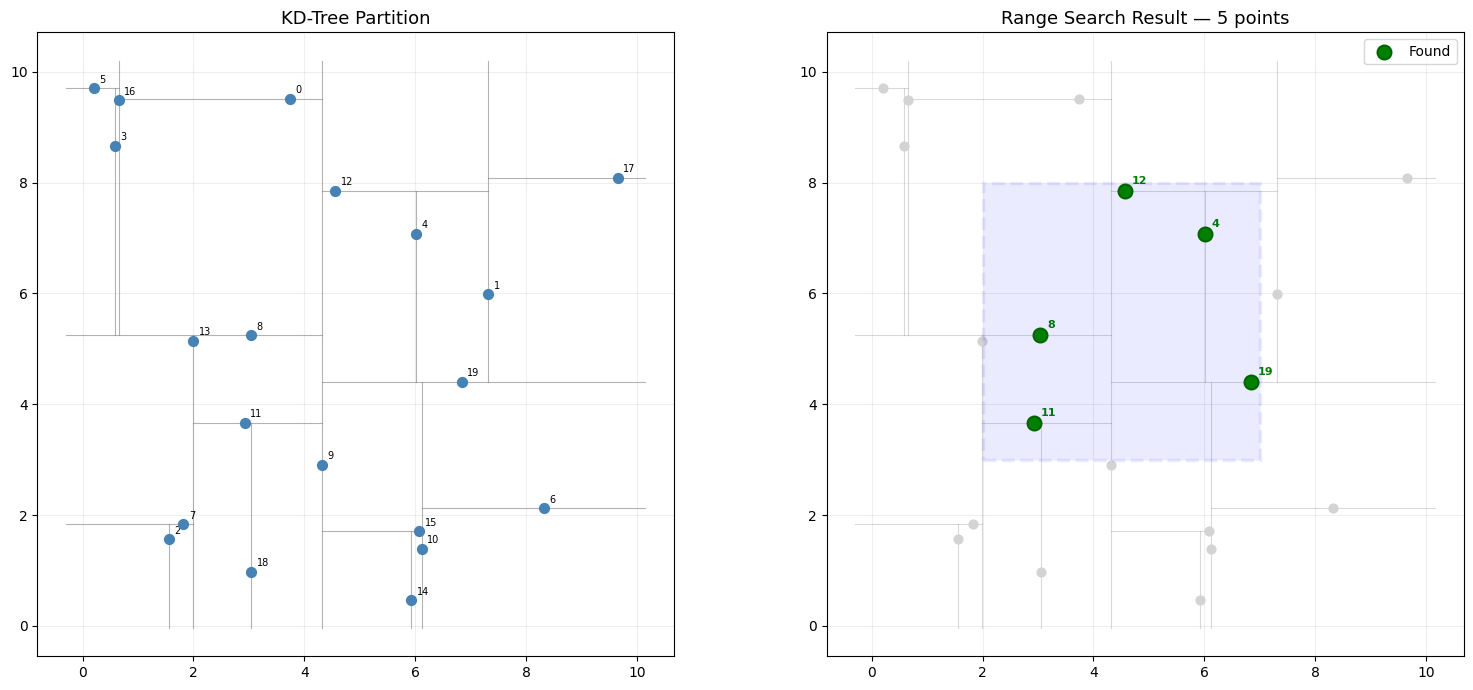

Summary complete ✓


In [7]:
# ============================================
# Static summary: KD-Tree splits + query result
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: full KD-Tree partition
ax = axes[0]
ax.scatter(points[:, 0], points[:, 1], c='steelblue', s=50, zorder=5)
for i, p in enumerate(points):
    ax.annotate(str(i), p, textcoords='offset points', xytext=(4, 4), fontsize=7)
draw_all_splits(ax, build_log, alpha=0.6)
ax.set_title('KD-Tree Partition', fontsize=13)
ax.set_aspect('equal'); ax.grid(True, alpha=0.2)

# Right: query result
ax = axes[1]
ax.scatter(points[:, 0], points[:, 1], c='lightgrey', s=40, zorder=3)
draw_all_splits(ax, build_log, alpha=0.3)
# Query rectangle
qw = query[1] - query[0]
qh = query[3] - query[2]
rect = patches.Rectangle((query[0], query[2]), qw, qh,
                          linewidth=2.5, edgecolor='blue',
                          facecolor='blue', alpha=0.08, linestyle='--', zorder=4)
ax.add_patch(rect)
# Reported points
if found:
    rp = points[found]
    ax.scatter(rp[:, 0], rp[:, 1], c='green', s=100, marker='o',
               edgecolors='darkgreen', linewidths=1.5, zorder=6, label='Found')
    for idx in found:
        ax.annotate(str(idx), points[idx], textcoords='offset points',
                    xytext=(5, 5), fontsize=8, color='green', fontweight='bold')
ax.set_title(f'Range Search Result — {len(found)} points', fontsize=13)
ax.set_aspect('equal'); ax.grid(True, alpha=0.2)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()
print("Summary complete ✓")